# Forest Cover Type Prediction
#### Chris, Dylan, Krista, I-Ching, Riley

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

from IPython.display import clear_output

# show all columns in DF
pd.set_option('display.max_columns', None)

## Introduction

In this notebook, we will explore data obtained from the US Geological Survey and USFS for 30x30 areas.  This study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices. Using this data, we are to best predict the type of cover that these forests provide, broken into 7 categories: spruce/fir, lodgepole pine, ponderosa pine, cottonwood/willow, aspen, douglas-fir, and krummholz.  

In [2]:
df = pd.read_csv('../data/train.csv', header=0)
df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   
4   5       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...      Soil_Type32  \
0            221             232            148     ...                0   
1            220             235            151     ...                0   
2            234             238            135     ...                0   
3            238             238            122     ...                0   
4            220             234            150     ...                0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5  
2            0            0            0           2  
3            0            0            0           2  
4            0            0            0           5  

[5 rows x 56 columns]

In [3]:
target_names = ['1 - Spruce/Fir', '2 - Lodgepole Pine', '3 - Ponderosa Pine', 
                '4 - Cottonwood/Willow', '5 - Aspen', '6 - Douglas-fir',
                '7 - Krummholz']

The first step in dealing with this data will be to clean up the raw data.

In [4]:
# Drop the ID and last column (Cover Type)
data = df.drop(['Id', df.columns[len(df.columns) - 1]], axis=1)
data.shape

(15120, 54)

In [5]:
# Store the cover type in labels
labels = df[df.columns[len(df.columns) - 1]]
labels.shape

(15120,)

In [6]:
for column in data.columns:
    print(data[column].describe(), "\n")

count    15120.000000
mean      2749.322553
std        417.678187
min       1863.000000
25%       2376.000000
50%       2752.000000
75%       3104.000000
max       3849.000000
Name: Elevation, dtype: float64 

count    15120.000000
mean       156.676653
std        110.085801
min          0.000000
25%         65.000000
50%        126.000000
75%        261.000000
max        360.000000
Name: Aspect, dtype: float64 

count    15120.000000
mean        16.501587
std          8.453927
min          0.000000
25%         10.000000
50%         15.000000
75%         22.000000
max         52.000000
Name: Slope, dtype: float64 

count    15120.000000
mean       227.195701
std        210.075296
min          0.000000
25%         67.000000
50%        180.000000
75%        330.000000
max       1343.000000
Name: Horizontal_Distance_To_Hydrology, dtype: float64 

count    15120.000000
mean        51.076521
std         61.239406
min       -146.000000
25%          5.000000
50%         32.000000
75%         

In [7]:
data.groupby(df[df.columns[len(df.columns) - 1]]).size()

# all cover types have an equal number of data points

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

## Helper Functions

In [8]:
def split_data(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, test_size=0.33, random_state=42)
    return X_train, y_train, X_test, y_test

# plot two columns
def my_scatter(col_1, col_2, figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    plt.scatter(col_1, col_2, c=labels.values,
                s=50, alpha=.5, cmap='viridis')
    plt.xlabel(col_1.name)
    plt.ylabel(col_2.name)

## Exploratory Data Analysis

Let's take a look at the data that we have.

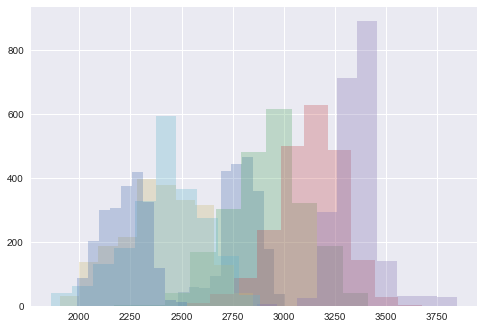

In [9]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

for label in labels.unique():
    plt.hist(data.Elevation[labels==label], **kwargs)

Elevation seems to be one of the more binnable for the cover type.  We made a note to focus on this variable.

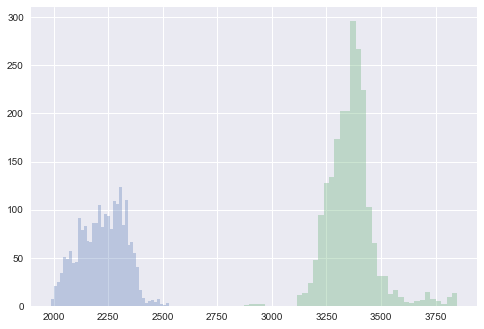

In [10]:
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=40)

plt.hist(data.Elevation[labels==4], **kwargs)
plt.hist(data.Elevation[labels==7], **kwargs);

Types 4 and 7 are nicely separated.

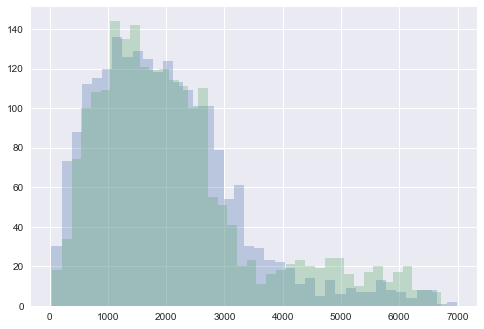

In [11]:
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==1], **kwargs)
plt.hist(data.Horizontal_Distance_To_Fire_Points[labels==2], **kwargs);

Types 1 and 2 have a lot of overlap on elevation. This could make them harder to predict.

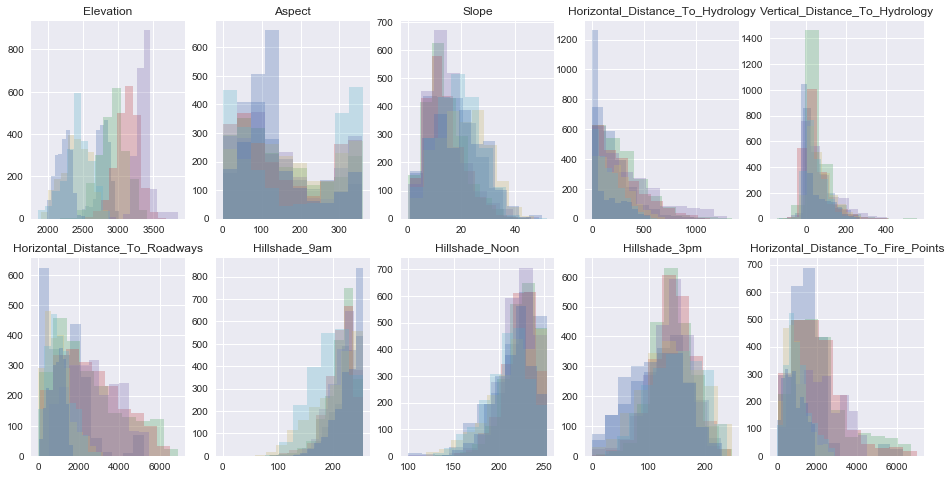

In [12]:
kwargs = dict(histtype='stepfilled', alpha=0.3)

fig, ax = plt.subplots(2, 5, figsize=(16, 8))
for i, axi in enumerate(ax.flat):
    for label in labels.unique():
        axi.hist(data.ix[labels==label, i], **kwargs)
    axi.set_title(data.columns[i])

From this, we can see that elevation has the most amount of variability between the different cover types.  Many of the other variables seem to overlap quite a lot for the different cover types, which indicates that they will not be very helpful in differentiating the different cover type.  The other notable features are the Horizontal and Veritcal distances to the disturbances, which have a bit more variation.  

In [13]:
my_columns = [x for x in data.columns.tolist() if "Soil_Type" not in x]
my_columns = [x for x in my_columns if "Wilderness" not in x]
df1 = data.reindex(columns=my_columns)

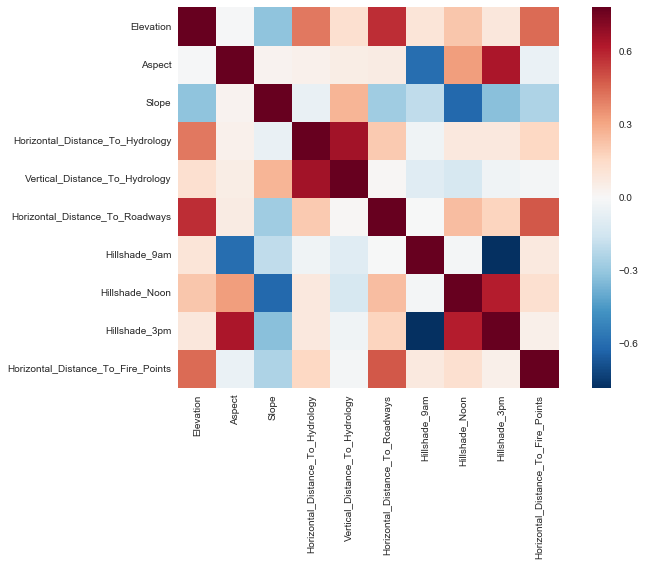

In [14]:
corrmat = df1.corr()
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(corrmat, vmax=.5, square=True);

From this, we can see several things. First, the vertical and horizonal distances are pretty strongly correlated.  Second, the HIllshade_3pm is positively correlated with Hillsahde_noon, and negatively correlated with Hillshade_9am.  We can also see that there is a positive correlation with aspect as well.

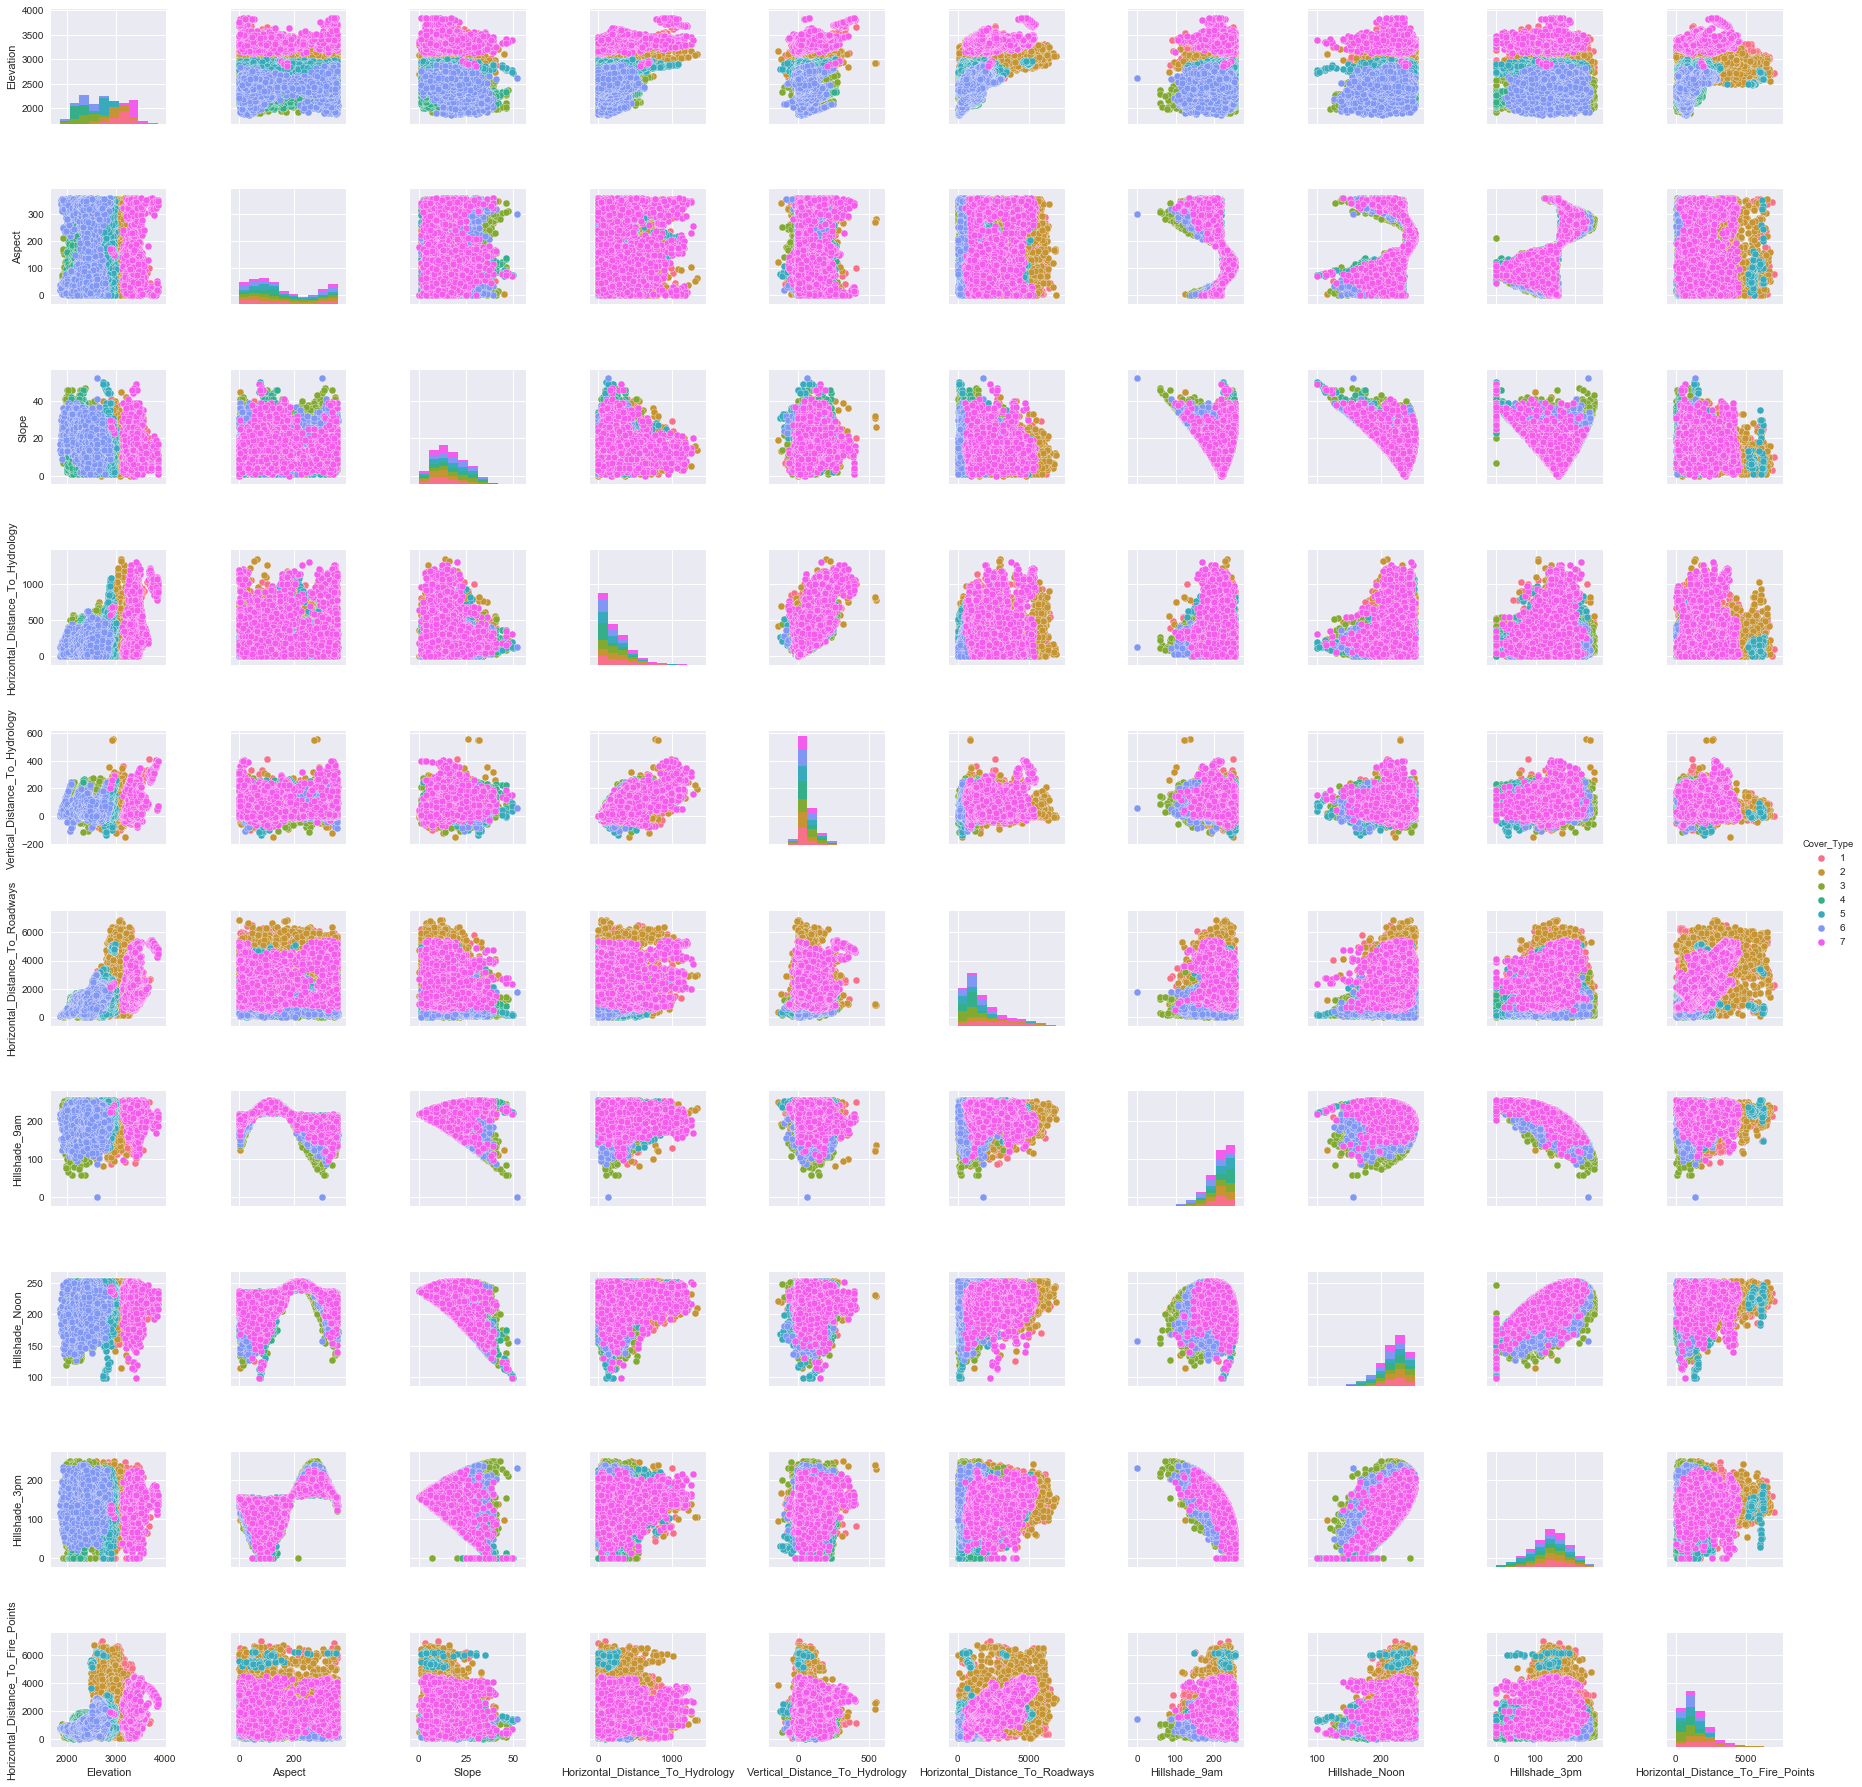

In [15]:
g = sns.pairplot(df, vars=my_columns, hue="Cover_Type")

In [16]:
# Count different soil types
data.loc[:, 'Soil_Type1':'Soil_Type40'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

In [17]:
col_names = df.columns.tolist()
A = np.array(col_names)
soil_types = [item for item in A if "Soil" in item]
for soil_type in soil_types:
    print (soil_type, df[soil_type].sum())

Soil_Type1 355
Soil_Type2 623
Soil_Type3 962
Soil_Type4 843
Soil_Type5 165
Soil_Type6 650
Soil_Type7 0
Soil_Type8 1
Soil_Type9 10
Soil_Type10 2142
Soil_Type11 406
Soil_Type12 227
Soil_Type13 476
Soil_Type14 169
Soil_Type15 0
Soil_Type16 114
Soil_Type17 612
Soil_Type18 60
Soil_Type19 46
Soil_Type20 139
Soil_Type21 16
Soil_Type22 345
Soil_Type23 757
Soil_Type24 257
Soil_Type25 1
Soil_Type26 54
Soil_Type27 15
Soil_Type28 9
Soil_Type29 1291
Soil_Type30 725
Soil_Type31 332
Soil_Type32 690
Soil_Type33 616
Soil_Type34 22
Soil_Type35 102
Soil_Type36 10
Soil_Type37 34
Soil_Type38 728
Soil_Type39 657
Soil_Type40 459


Soil types don't seem to be very consisten, and some soil types have 0 data points, which may need to be dropped.  Overall, we may find that the soil type won't be too helpful.

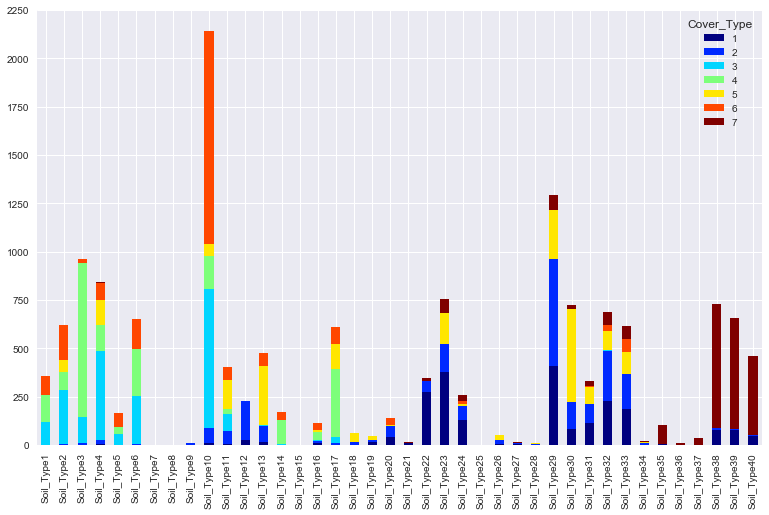

In [18]:
types_sum = df[soil_types].groupby(df['Cover_Type']).sum()
types_sum.T.plot(kind='bar', stacked=True, figsize=(13,8), cmap='jet')

We can see some subtle differences when plotting the cover type that different soils have.  For example, cover type 7 seems to be heavily on the soil types 38,39,40.  In addition, cover type 6 seems to trend towards the lower soil types.  Other points seem to be a bit more scattered.

In [19]:
# Count at different wilderness areass
data.loc[:, 'Wilderness_Area1':'Wilderness_Area4'].sum(axis=1).describe()

count    15120.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

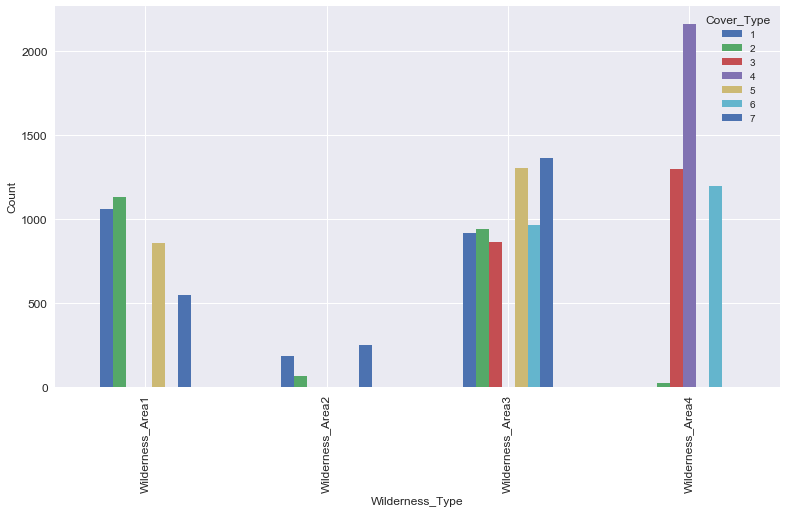

In [20]:
col_names_wilderness = [x for x in df.columns.tolist() if "Wilderness" in x]
types_sum = df[col_names_wilderness].groupby(df['Cover_Type']).sum()
ax = types_sum.T.plot(kind='bar', figsize=(13, 7), legend=True, fontsize=12)
ax.set_xlabel("Wilderness_Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

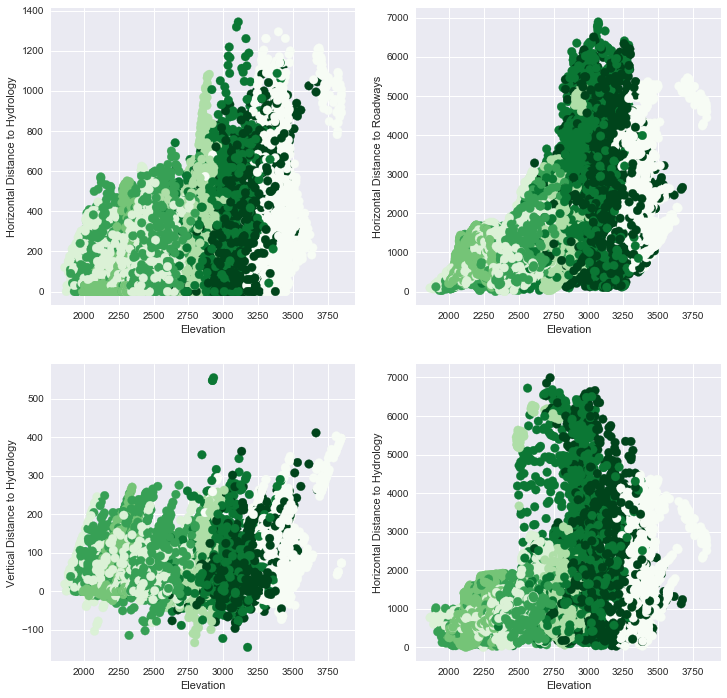

In [21]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology") 

plt.show()

Looking at this, we can see with a small adjustment to the elevation values in relation to the horizontal distance to hydrology, we can get the labels differentiated better.  We try to do this in the next figure.

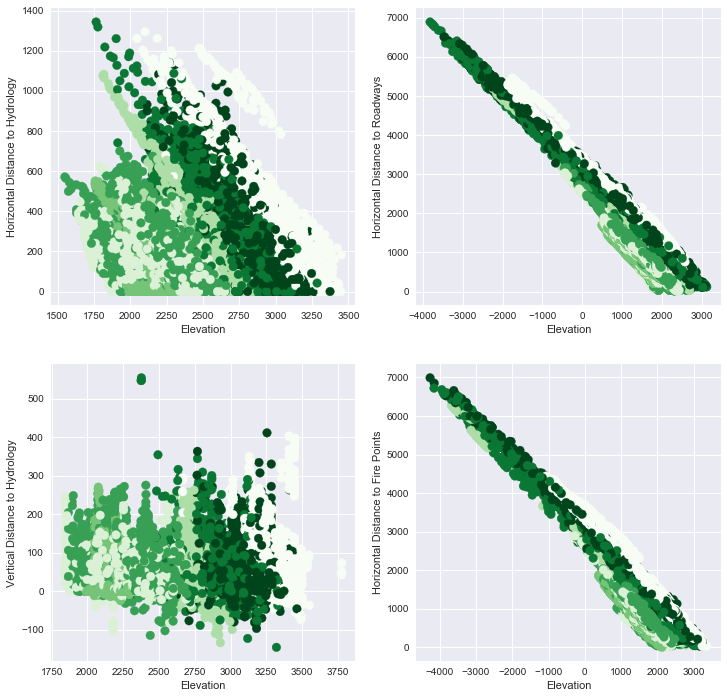

In [22]:
#Elevation vs Horizontal Distance to Hydrology 
plt.figure(figsize=(12,12)) 
plt.subplot(221)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Hydrology, df.Horizontal_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Hydrology")
plt.subplot(222)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Roadways, df.Horizontal_Distance_To_Roadways, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Roadways") 
plt.subplot(223)
plt.scatter(df.Elevation - df.Vertical_Distance_To_Hydrology, df.Vertical_Distance_To_Hydrology, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Vertical Distance to Hydrology")
plt.subplot(224)
plt.scatter(df.Elevation - df.Horizontal_Distance_To_Fire_Points, df.Horizontal_Distance_To_Fire_Points, c=df.Cover_Type, s=75, cmap=plt.cm.Greens_r) 
plt.xlabel("Elevation") 
plt.ylabel("Horizontal Distance to Fire Points") 

plt.show()

We can see that the cover types cluster a bit better.  We can see if adjusting this will help with the model.

# Dimensionality Reduction

We'd  like to reduce our feature space to make our modelling simpler, while hopefully preserving the variablility/information in our data.

Below we explore how much variance is explained as we increase the number of PCA components. We found that there was not a logical cut off that allowed us to both reduce the number of features, and preserve variance within the data.

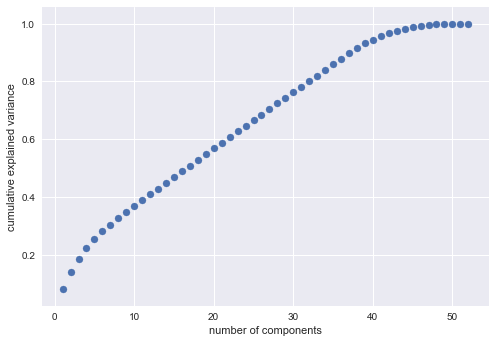

In [23]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=52)
pca.fit(X_train_std)
plt.scatter(range(1,53),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

We'd also like to see if on an extremely simplified case with only 2 PCA components if we could pick find visibly separable data.

In [24]:
pca = PCA(n_components=2)
X_2D = pca.fit_transform(X_train_std)

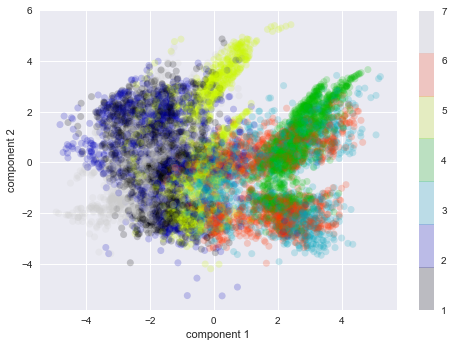

In [25]:
plt.scatter(X_2D[:, 0], X_2D[:, 1],
            c=y_train, edgecolor='none', alpha=0.2,
            cmap=plt.cm.get_cmap('nipy_spectral', 7))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

After additional attempts, we didn't find strong evidence that PCA was going to help us much. See the the appendix at the end of this notebook for additional trials with PCA

# Feature Selection

In [26]:
def remove_features(data, feature_list):
    new_data = data.copy(deep=True)
    new_data.drop(new_data.columns[feature_list], axis=1, inplace=True)
    return new_data

In [27]:
# baseline
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

lr_accuracy = np.mean(y_pred == y_test)
lr_accuracy

0.67715430861723447

## Stepwise selection with LogisticRegression

In [28]:
X_train, y_train, X_test, y_test = split_data(data, labels)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

max_columns = data.shape[1]

max_accuracy = 0
bad_features = []
for i in range(0, max_columns):
    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
    lr_pipe.fit(X_train.as_matrix()[:, 0:i+1], y_train)
    y_pred = lr_pipe.predict(X_test.as_matrix()[:, 0:i+1])
    
    new_accurancy = np.mean(y_pred == y_test)
    
    if new_accurancy < max_accuracy:
        bad_features.append(i)
    
    if new_accurancy > max_accuracy:
        max_accuracy = new_accurancy
    
    print("Column {}:".format(i), new_accurancy, 'worse' if i in bad_features else '')

Column 0: 0.533266533066 
Column 1: 0.525651302605 worse
Column 2: 0.528056112224 worse
Column 3: 0.533867735471 
Column 4: 0.538276553106 
Column 5: 0.536472945892 worse
Column 6: 0.569338677355 
Column 7: 0.586973947896 
Column 8: 0.586973947896 
Column 9: 0.582765531062 worse
Column 10: 0.591783567134 
Column 11: 0.593386773547 
Column 12: 0.601002004008 
Column 13: 0.601603206413 
Column 14: 0.602004008016 
Column 15: 0.602805611222 
Column 16: 0.611623246493 
Column 17: 0.631062124248 
Column 18: 0.631863727455 
Column 19: 0.633066132265 
Column 20: 0.633066132265 
Column 21: 0.633066132265 
Column 22: 0.633266533066 
Column 23: 0.650901803607 
Column 24: 0.649899799599 worse
Column 25: 0.657314629259 
Column 26: 0.653907815631 worse
Column 27: 0.655711422846 worse
Column 28: 0.655711422846 worse
Column 29: 0.659318637275 
Column 30: 0.655310621242 worse
Column 31: 0.655911823647 worse
Column 32: 0.656913827655 worse
Column 33: 0.660320641283 
Column 34: 0.659919839679 worse
Colum

In [29]:
# New accuracy with removed features
new_data = remove_features(data, bad_features)

print(new_data.shape)

X_train, y_train, X_test, y_test = split_data(new_data, labels)

lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())
    
lr_pipe.fit(X_train, y_train)
y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
new_accuracy

(15120, 27)


0.65050100200400807

After removing features that made the model worse the overall accuracy has gone down with the LogisticRegression compared to the same model with all the features

## Ridge Regression to choose features

In [30]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(StandardScaler(), RidgeClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)

coefs = lr_pipe.named_steps['ridgeclassifier'].coef_

indexes = np.nonzero(coefs == 0)[1]
zero_features = np.unique(indexes)

print('Columns to remove:')
for i in zero_features:
    print(data.columns[i])
    
print('Accuracy with Ridge Regression: {}'.format(new_accuracy))

Columns to remove:
Soil_Type7
Soil_Type15
Accuracy with Ridge Regression: 0.6362725450901804


Ridge Regression finds the two soil types with no examples in the training set. Performance is worse with this classifier compared to Linear Regression.

## Random Forest Feature Selection

In [31]:
X_train, y_train, X_test, y_test = split_data(data, labels)

lr_pipe = make_pipeline(RandomForestClassifier())
lr_pipe.fit(X_train, y_train)

y_pred = lr_pipe.predict(X_test)

new_accuracy = np.mean(y_pred == y_test)
print('Random Forest accuracy: {}'.format(new_accuracy), '\n')

features = lr_pipe.named_steps['randomforestclassifier'].feature_importances_

features = sorted(zip(features, data.columns), reverse=True)
for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

Random Forest accuracy: 0.825250501002004 

0.2620, Elevation
0.0900, Horizontal_Distance_To_Roadways
0.0745, Horizontal_Distance_To_Fire_Points
0.0602, Horizontal_Distance_To_Hydrology
0.0544, Vertical_Distance_To_Hydrology
0.0529, Hillshade_9am
0.0507, Aspect
0.0461, Hillshade_3pm
0.0455, Hillshade_Noon
0.0369, Slope
0.0235, Wilderness_Area1
0.0224, Soil_Type3
0.0178, Soil_Type39
0.0166, Wilderness_Area3
0.0142, Soil_Type38
0.0141, Soil_Type10
0.0140, Wilderness_Area4
0.0106, Soil_Type4
0.0097, Soil_Type40
0.0093, Soil_Type30
0.0067, Soil_Type29
0.0066, Soil_Type22
0.0062, Soil_Type17
0.0062, Soil_Type23
0.0056, Soil_Type13
0.0050, Soil_Type32
0.0050, Soil_Type2
0.0043, Soil_Type12
0.0036, Soil_Type33
0.0032, Soil_Type11
0.0031, Soil_Type6
0.0029, Wilderness_Area2
0.0027, Soil_Type24
0.0022, Soil_Type31
0.0017, Soil_Type20
0.0016, Soil_Type1
0.0014, Soil_Type35
0.0011, Soil_Type5
0.0010, Soil_Type14
0.0009, Soil_Type16
0.0008, Soil_Type18
0.0007, Soil_Type26
0.0004, Soil_Type37
0.000

The Random Forest Classifier finds Elevation and Horizontal distance to be the most important features. This classifier performs well and does feature selection.

# Feature Engineering

After many trials the only feature that we saw significant accuracy benefits from was adding a new variable, which took the mean of all of the horizontal distance metrics to our model. Our intuition around this metric could be simplified down to average distance to "disturbance", if we consider fires, roads, and water sources of potential "disturbance."

In [32]:
## Base Line Random Forest
def base_line_rfc(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)
    lr_pipe = make_pipeline(RandomForestClassifier())
    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_rfc_accuracy = base_line_rfc(data)
base_rfc_accuracy

0.81923847695390783

In [33]:
## Base Line Logistic
def base_line_lr(data):
    X_train, y_train, X_test, y_test = split_data(data, labels)

    lr_pipe = make_pipeline(StandardScaler(), LogisticRegression())

    lr_pipe.fit(X_train, y_train)
    y_pred = lr_pipe.predict(X_test)

    accuracy = np.mean(y_pred == y_test)
    return accuracy

base_lr_accuracy = base_line_lr(data)
base_lr_accuracy

0.67715430861723447

In [34]:
def print_base_results(new_data):
    print('Base RFC: {:.4f}, New RFC: {:.4f}'.format(base_rfc_accuracy, base_line_rfc(new_data)))
    print('Base LR:  {:.4f}, New LR:  {:.4f}'.format(base_lr_accuracy, base_line_lr(new_data)))

## Polynomial Features

In [35]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), LogisticRegression())
c_vals = [20, 25, 30, 35]
tol = [.01]
penalty = ['l2']
degree = range(2, 3)
param_grid = {
    'polynomialfeatures__degree': degree,
    'logisticregression__C': c_vals,
    'logisticregression__tol': tol,
    'logisticregression__penalty': penalty,
}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

X_train, y_train, X_test, y_test = split_data(data, labels)

%time grid.fit(X_train, y_train)
print('Best params for Logistic Regression: {}'. \
      format(grid.best_params_))

best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
new_accuracy = np.mean(y_pred == y_test)
print('Base LR: {:.4f}, With Polynomials: {:.4f}'.format(base_lr_accuracy, new_accuracy))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.5min finished


CPU times: user 2min 21s, sys: 665 ms, total: 2min 22s
Wall time: 18min 54s
Best params for Logistic Regression: {'logisticregression__C': 20, 'logisticregression__penalty': 'l2', 'logisticregression__tol': 0.01, 'polynomialfeatures__degree': 2}
Base LR: 0.6772, With Polynomials: 0.7860


## Mean Disturbances Feature

In [36]:
def mean_disturb_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_disturb'] = (data.Horizontal_Distance_To_Fire_Points \
                            + data.Horizontal_Distance_To_Hydrology \
                            + data.Horizontal_Distance_To_Roadways) / 3
    return new_data

In [37]:
new_data = mean_disturb_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8419
Base LR:  0.6772, New LR:  0.6772


## Mean Fire Hydro Feature

In [38]:
def mean_fire_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['mean_fire_hydro'] = (data.Horizontal_Distance_To_Fire_Points \
                            + data.Horizontal_Distance_To_Hydrology) / 2
    return new_data

In [39]:
new_data = mean_fire_hydro_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8331
Base LR:  0.6772, New LR:  0.6772


## Plotting Features

### New elevation feature

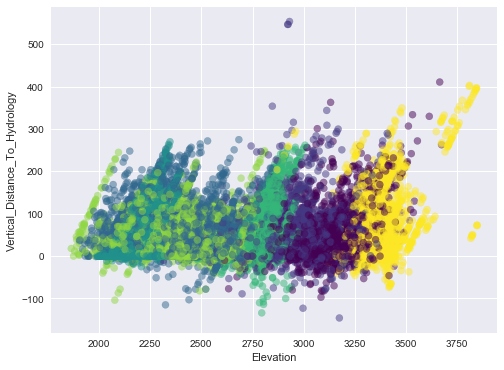

In [40]:
my_scatter(data.Elevation, data.Vertical_Distance_To_Hydrology)

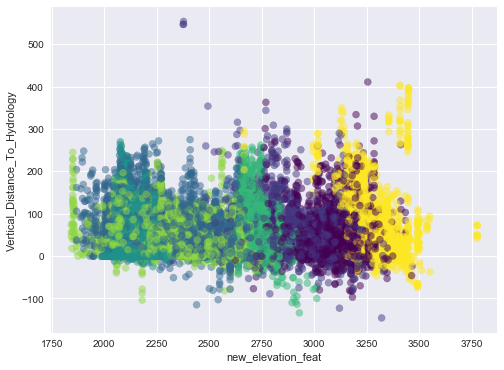

In [41]:
def new_elevation_feat(data):
    new_data = data.copy(deep=True)
    new_feature = new_data.Elevation - new_data.Vertical_Distance_To_Hydrology
    new_data['new_elevation_feat'] = new_feature
    return new_data

new_data = new_elevation_feat(data)
my_scatter(new_data.new_elevation_feat, new_data.Vertical_Distance_To_Hydrology)

In [42]:
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8393
Base LR:  0.6772, New LR:  0.6766


### New Elevation Hydro Feature

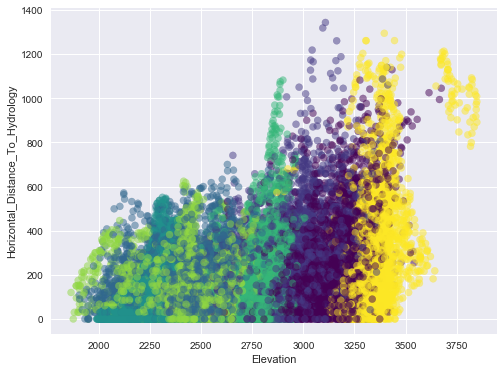

In [43]:
my_scatter(data.Elevation, data.Horizontal_Distance_To_Hydrology)

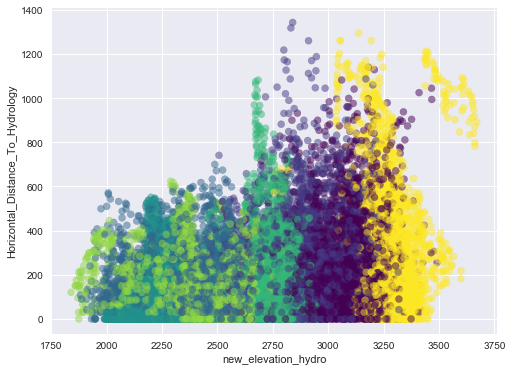

In [44]:
def new_elevation_hydro_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_elevation_hydro'] = new_data.Elevation - new_data.Horizontal_Distance_To_Hydrology * .2
    return new_data

new_data = new_elevation_hydro_feat(data)
my_scatter(new_data.new_elevation_hydro, data.Horizontal_Distance_To_Hydrology)

In [45]:
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8265
Base LR:  0.6772, New LR:  0.6764


### New Hillshade Feature

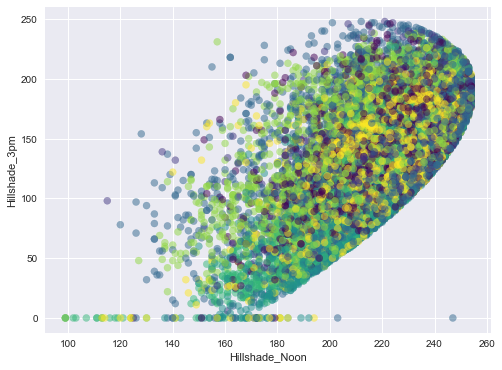

In [46]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

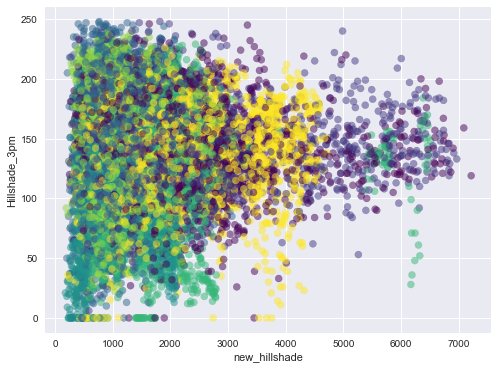

In [47]:
def new_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade'] = data.Hillshade_Noon + data.Horizontal_Distance_To_Fire_Points
    return new_data

new_data = new_hillshade_feat(data)
my_scatter(new_data.new_hillshade, new_data.Hillshade_3pm)

In [48]:
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8315
Base LR:  0.6772, New LR:  0.6772


### New Hillshade_Hillshade Feature

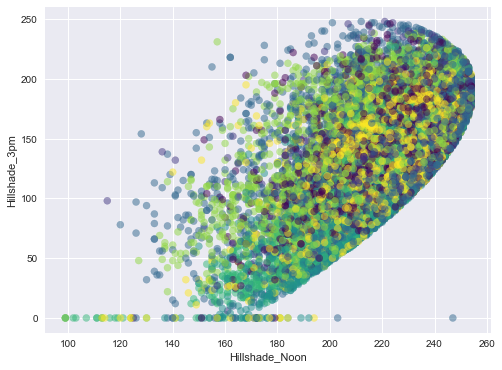

In [49]:
my_scatter(data.Hillshade_Noon, data.Hillshade_3pm)

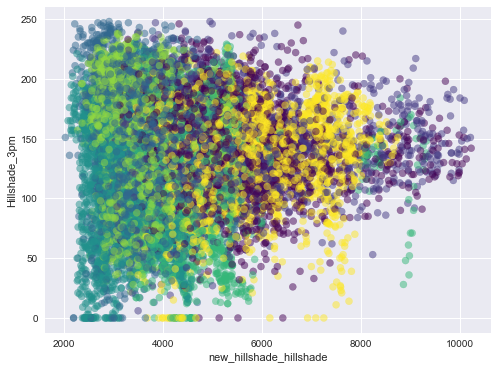

In [50]:
def new_hillshade_hillshade_feat(data):
    new_data = data.copy(deep=True)
    new_data['new_hillshade_hillshade'] = data.Hillshade_Noon - data.Aspect + \
        data.Horizontal_Distance_To_Fire_Points + data.Elevation + data.Horizontal_Distance_To_Hydrology
    return new_data

new_data = new_hillshade_hillshade_feat(data)
my_scatter(new_data.new_hillshade_hillshade, new_data.Hillshade_3pm)

In [51]:
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8317
Base LR:  0.6772, New LR:  0.6772


In [52]:
# #Mean distance to Disturbances 
# means_train = pd.DataFrame()
# means_test = pd.DataFrame()

# means_train['Mean_Disturbances'] = (X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology + X_train.Horizontal_Distance_To_Roadways) / 3 
# means_test['Mean_Disturbances'] = (X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology + X_test.Horizontal_Distance_To_Roadways) / 3 

# means_train['Mean_Fire_Hyd']=(X_train.Horizontal_Distance_To_Fire_Points + X_train.Horizontal_Distance_To_Hydrology) / 2
# means_test['Mean_Fire_Hyd']=(X_test.Horizontal_Distance_To_Fire_Points + X_test.Horizontal_Distance_To_Hydrology) / 2 

# means_train.index = X_train.index
# means_test.index = X_test.index

# X_train_means = pd.concat([X_train,means_train], axis =1, join_axes=[X_train.index])
# X_test_means = pd.concat([X_test,means_test], axis=1, join_axes=[X_test.index])

# # Test on a model

# without_mean = []
# with_mean = []
# for i in range(10):
#     log = RandomForestClassifier()
#     log.fit(X_train, y_train)
#     without_mean.append(log.score(X_test, y_test))

#     log.fit(X_train_means, y_train)
#     with_mean.append(log.score(X_test_means, y_test))
# print ("Accuracy without extra mean feature is {}".format(np.mean(without_mean)))
# print ("Accuracy with extra mean feature is {}".format(np.mean(with_mean)))

We know we want to keep this feature, so we'll permanently incorporate it into our data.

In [53]:
# # Adding this feature permanently to our data 
# X_train_std = pd.DataFrame(X_train_std)
# X_test_std = pd.DataFrame(X_test_std)

In [54]:
# X_train_std.columns, X_train_std.index = X_train.columns, X_train.index
# X_test_std.columns, X_test_std.index = X_test.columns, X_test.index

In [55]:
# X_train_std = pd.concat([X_train_std,means_train], axis =1, join_axes=[X_train_std.index])
# X_test_std = pd.concat([X_test_std,means_test], axis =1, join_axes=[X_test_std.index])

In [56]:
# X_train_std.head()

In [57]:
# #Adjusting distance to hydrology and roadways 
# adj_train = pd.DataFrame()
# adj_test = pd.DataFrame()

# #Elevation adjusted by Horizontal distance to Hyrdrology 
# adj_train['Elev_to_HD_Hyd']=X_train.Elevation - X_train.Horizontal_Distance_To_Hydrology 
# adj_test['Elev_to_HD_Hyd']=X_test.Elevation - X_test.Horizontal_Distance_To_Hydrology 

# #Elevation adjusted by Horizontal distance to Roadways 
# adj_train['Elev_to_HD_Road']=X_train.Elevation - X_train.Horizontal_Distance_To_Roadways 
# adj_test['Elev_to_HD_Road']=X_test.Elevation - X_test.Horizontal_Distance_To_Roadways 

# #Elevation adjusted by Vertical distance to Roadways 
# adj_train['Elev_to_VD_Hyd']=X_train.Elevation - X_train.Vertical_Distance_To_Hydrology 
# adj_test['Elev_to_VD_Hyd']=X_test.Elevation - X_test.Vertical_Distance_To_Hydrology 

# #Elevation adjusted by Horizontal distance to Fire Points 
# adj_train['Elev_to_Fire_Points']=X_train.Elevation - X_train.Horizontal_Distance_To_Fire_Points 
# adj_test['Elev_to_Fire_Points']=X_test.Elevation - X_test.Horizontal_Distance_To_Fire_Points 

# adj_train.index = X_train.index
# adj_test.index = X_test.index

# X_train_adj = pd.concat([X_train,adj_train], axis =1, join_axes=[X_train.index])
# X_test_adj = pd.concat([X_test,adj_test], axis=1, join_axes=[X_test.index])

# # Test on a model

# without_adj = []
# with_adj = []
# for i in range(10):
#     log = RandomForestClassifier()
#     log.fit(X_train, y_train)
#     without_adj.append(log.score(X_test, y_test))

#     log.fit(X_train_adj, y_train)
#     with_adj.append(log.score(X_test_adj, y_test))
# print "Accuracy without extra adj feature is {}".format(np.mean(without_adj))
# print "Accuracy with extra adj feature is {}".format(np.mean(with_adj))


# Model Selection

For a multiple category classification problem without text data, sklearn's chat suggested that we try KNN, SVM, and ensemble methods. We'll use KNN as our baseline and then try differnt ensemble and SVM methods. After we find the best emsemble and SVM model, we will tune the parameters. 

http://scikit-learn.org/stable/tutorial/machine_learning_map/

SVM are good for high dimensional spaces and is very customizable. They have some nice theoretical guarantees that prevent overfitting and have a simple decision boundary

Ensemble methods combine predictions over several weaker estimators. They are better with multiple categories for classification, but tend to have more complicated decision boundaries and can overfit if not supervised.

In [58]:
X_train, y_train, X_test, y_test = split_data(data, labels)

# Baseline KNN model

In [73]:
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())
knn_pipe.fit(X_train, y_train)
y_pred = knn_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.68      0.65      0.66       679
   2 - Lodgepole Pine       0.69      0.57      0.62       722
   3 - Ponderosa Pine       0.76      0.70      0.73       704
4 - Cottonwood/Willow       0.86      0.95      0.90       739
            5 - Aspen       0.82      0.92      0.87       721
      6 - Douglas-fir       0.76      0.77      0.77       722
        7 - Krummholz       0.92      0.95      0.94       703

          avg / total       0.78      0.79      0.79      4990



# Ensemble methods

We will try a bunch of ensemble methods out of the box.  We'll see if averging methods such as random trees, extra trees workds better by reducing the combined variance of the estimator or if boosting methods, which reduce the bias of the combined estimator are better on our model.  

# Random Forests

In [60]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.71      0.74      0.72       679
   2 - Lodgepole Pine       0.73      0.64      0.68       722
   3 - Ponderosa Pine       0.78      0.81      0.79       704
4 - Cottonwood/Willow       0.92      0.97      0.94       739
            5 - Aspen       0.89      0.91      0.90       721
      6 - Douglas-fir       0.83      0.80      0.81       722
        7 - Krummholz       0.94      0.96      0.95       703

          avg / total       0.83      0.83      0.83      4990



# Extra Trees

In [61]:
model = ExtraTreesClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.70      0.75      0.73       679
   2 - Lodgepole Pine       0.73      0.62      0.67       722
   3 - Ponderosa Pine       0.79      0.82      0.81       704
4 - Cottonwood/Willow       0.92      0.96      0.94       739
            5 - Aspen       0.87      0.91      0.89       721
      6 - Douglas-fir       0.83      0.81      0.82       722
        7 - Krummholz       0.94      0.95      0.94       703

          avg / total       0.83      0.83      0.83      4990



# AdaBoost

In [62]:
model = AdaBoostClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.32      0.44      0.37       679
   2 - Lodgepole Pine       0.45      0.07      0.13       722
   3 - Ponderosa Pine       0.42      0.02      0.05       704
4 - Cottonwood/Willow       0.00      0.00      0.00       739
            5 - Aspen       0.40      0.84      0.54       721
      6 - Douglas-fir       0.29      0.86      0.43       722
        7 - Krummholz       0.58      0.21      0.31       703

          avg / total       0.35      0.35      0.26      4990



/Users/chrisfleisch/anaconda3/envs/w207_final/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# GradientBoosting

In [63]:
model = GradientBoostingClassifier()
model.fit (X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.71      0.71      0.71       679
   2 - Lodgepole Pine       0.72      0.58      0.64       722
   3 - Ponderosa Pine       0.75      0.72      0.74       704
4 - Cottonwood/Willow       0.91      0.96      0.94       739
            5 - Aspen       0.80      0.89      0.84       721
      6 - Douglas-fir       0.77      0.77      0.77       722
        7 - Krummholz       0.91      0.96      0.93       703

          avg / total       0.80      0.80      0.80      4990



It looks like averaging methods worked best on our data set.  Extra trees was the best estimaor with an average prevision, recall, and recall of 86%.  This is an improvement over our KNN baseline of 80%. 

# SVM

In [74]:
svm_pipe = make_pipeline(StandardScaler(), SVC())
svm_pipe.fit (X_train, y_train)
y_pred = svm_pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.67      0.73      0.70       679
   2 - Lodgepole Pine       0.70      0.55      0.62       722
   3 - Ponderosa Pine       0.69      0.62      0.65       704
4 - Cottonwood/Willow       0.80      0.96      0.87       739
            5 - Aspen       0.80      0.85      0.82       721
      6 - Douglas-fir       0.70      0.68      0.69       722
        7 - Krummholz       0.93      0.89      0.91       703

          avg / total       0.75      0.76      0.75      4990



# Parameter Tuning With New Features

In [99]:

### Add new features 
def get_new_features_data_rf(data):
    new_feature_funcs = [mean_disturb_feat, mean_fire_hydro_feat, new_elevation_feat,
                         new_elevation_hydro_feat, new_hillshade_feat,
                         new_hillshade_hillshade_feat]
    new_data = data.copy(deep=True)
    for func in new_feature_funcs:
        new_data = func(new_data)

    return new_data

new_data = get_new_features_data_rf(data)
new_data.head()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points           ...             Soil_Type37  \
0                                6279           ...                       0   
1                                6225           ...                       0   
2                                6121           ...                       0   
3                                6211           ...                       0   
4                                6172           ...                       0   

   Soil_Type38  Soil_Type39  Soil_Type40  mean_disturb  mean_fire_hydro  \
0            0            0            0   2349.000000           3268.5   
1            0            0            0   2275.666667           3218.5   
2            0            0            0   3189.666667           3194.5   
3            0            0            0   3181.000000           3226.5   
4            0            0            0   2238.666667           3162.5   

   new_elevation_feat  new_elevation_hydro  new_hillshade  \
0                2596               2544.4           6511   
1                2596               2547.6           6460   
2                2739               2750.4           6359   
3                2667               2736.6           6449   
4                2596               2564.4           6406   

   new_hillshade_hillshade  
0                     9314  
1                     9206  
2                     9292  
3                     9321  
4                     9109  

[5 rows x 60 columns]

## Random Forest

In [66]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(RandomForestClassifier())

param_grid = {
    'randomforestclassifier__n_estimators': [1000,], 
    'randomforestclassifier__criterion': ['entropy',],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__max_depth': [None, 35, 50],
    'randomforestclassifier__bootstrap': [False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.7min finished


CPU times: user 32.1 s, sys: 807 ms, total: 33 s
Wall time: 2min 14s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'randomforestclassifier__max_depth': [None, 35, 50], 'randomforestclassifier__bootstrap': [False], 'randomforestclassifier__criterion': ['entropy'], 'randomforestclassifier__n_estimators': [1000], 'randomforestclassifier__max_features': ['sqrt']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [67]:
print(grid.best_params_)
best_rfc = grid.best_estimator_
y_pred = best_rfc.predict(X_test)
print(np.mean(y_pred == y_test))
print(classification_report(y_test, y_pred, target_names=target_names))

{'randomforestclassifier__bootstrap': False, 'randomforestclassifier__n_estimators': 1000, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_features': 'sqrt'}
0.890380761523
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.80      0.81      0.80       679
   2 - Lodgepole Pine       0.82      0.72      0.77       722
   3 - Ponderosa Pine       0.88      0.87      0.87       704
4 - Cottonwood/Willow       0.95      0.99      0.97       739
            5 - Aspen       0.91      0.95      0.93       721
      6 - Douglas-fir       0.90      0.91      0.90       722
        7 - Krummholz       0.96      0.98      0.97       703

          avg / total       0.89      0.89      0.89      4990



In [120]:
# Show importance of new features

features = best_rfc.named_steps['randomforestclassifier'].feature_importances_
features = sorted(zip(features, new_data.columns), reverse=True)

for f in features:
    print('{:6.4f}, {}'.format(f[0], f[1]))

0.1507, new_elevation_hydro
0.1425, new_elevation_feat
0.1312, Elevation
0.0484, mean_disturb
0.0476, Horizontal_Distance_To_Roadways
0.0451, new_hillshade_hillshade
0.0421, Wilderness_Area4
0.0329, Horizontal_Distance_To_Hydrology
0.0311, mean_fire_hydro
0.0294, new_hillshade
0.0287, Horizontal_Distance_To_Fire_Points
0.0273, Vertical_Distance_To_Hydrology
0.0273, Hillshade_9am
0.0250, Aspect
0.0228, Hillshade_Noon
0.0218, Hillshade_3pm
0.0208, Wilderness_Area1
0.0168, Slope
0.0162, Wilderness_Area3
0.0154, Soil_Type10
0.0100, Soil_Type3
0.0080, Soil_Type39
0.0079, Soil_Type38
0.0067, Soil_Type4
0.0047, Soil_Type30
0.0039, Soil_Type29
0.0034, Soil_Type40
0.0032, Soil_Type2
0.0029, Soil_Type17
0.0026, Soil_Type32
0.0026, Soil_Type23
0.0024, Wilderness_Area2
0.0024, Soil_Type13
0.0023, Soil_Type33
0.0021, Soil_Type22
0.0019, Soil_Type12
0.0017, Soil_Type6
0.0016, Soil_Type11
0.0010, Soil_Type24
0.0010, Soil_Type31
0.0009, Soil_Type20
0.0007, Soil_Type5
0.0007, Soil_Type1
0.0006, Soil_Ty

## Extra Trees

In [68]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)

pipe = make_pipeline(ExtraTreesClassifier())

param_grid = {
    'extratreesclassifier__n_estimators': [1000, 2000, 3000], 
    'extratreesclassifier__criterion': ['entropy', 'gini'],
    'extratreesclassifier__max_features': ['auto','sqrt', 'log2', None],
    'extratreesclassifier__max_depth': [25, 30, 35],
    'extratreesclassifier__bootstrap': [True, False],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, verbose=1)
%time grid.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 49.8min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 94.8min finished


CPU times: user 35.1 s, sys: 5.43 s, total: 40.5 s
Wall time: 1h 35min 14s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('extratreesclassifier', ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'extratreesclassifier__max_features': ['auto', 'sqrt', 'log2', None], 'extratreesclassifier__max_depth': [25, 30, 35], 'extratreesclassifier__n_estimators': [1000, 2000, 3000], 'extratreesclassifier__bootstrap': [True, False], 'extratreesclassifier__criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [69]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'extratreesclassifier__max_features': 'auto', 'extratreesclassifier__max_depth': 35, 'extratreesclassifier__n_estimators': 2000, 'extratreesclassifier__bootstrap': False, 'extratreesclassifier__criterion': 'entropy'}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.81      0.79      0.80       679
   2 - Lodgepole Pine       0.82      0.73      0.77       722
   3 - Ponderosa Pine       0.88      0.86      0.87       704
4 - Cottonwood/Willow       0.93      0.98      0.95       739
            5 - Aspen       0.92      0.97      0.94       721
      6 - Douglas-fir       0.89      0.90      0.90       722
        7 - Krummholz       0.96      0.98      0.97       703

          avg / total       0.89      0.89      0.89      4990



## SVM

In [75]:
X_train, y_train, X_test, y_test = split_data(new_data, labels)
svm_pipe = make_pipeline(StandardScaler(), SVC())

param_grid = {
    'svc__kernel': ['linear', 'rbf'],  
    'svc__C': [50, 100, 200], 
    'svc__gamma': [.01, .05, .1]
} 
grid = GridSearchCV(svm_pipe, param_grid, cv=5, n_jobs=-1)
%time grid.fit(X_train, y_train)

CPU times: user 5.59 s, sys: 307 ms, total: 5.89 s
Wall time: 11min 5s


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'svc__C': [50, 100, 200], 'svc__kernel': ['linear', 'rbf'], 'svc__gamma': [0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [76]:
print(grid.best_params_)
model = grid.best_estimator_
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

{'svc__C': 100, 'svc__kernel': 'rbf', 'svc__gamma': 0.05}
                       precision    recall  f1-score   support

       1 - Spruce/Fir       0.73      0.73      0.73       679
   2 - Lodgepole Pine       0.73      0.66      0.69       722
   3 - Ponderosa Pine       0.82      0.77      0.79       704
4 - Cottonwood/Willow       0.91      0.96      0.93       739
            5 - Aspen       0.88      0.93      0.91       721
      6 - Douglas-fir       0.83      0.85      0.84       722
        7 - Krummholz       0.94      0.97      0.95       703

          avg / total       0.84      0.84      0.84      4990



With parameter tuning, we were able to get the accuracy up to.

# Error analysis

In [112]:
rfc = best_rfc.get_params()['randomforestclassifier']

In [114]:
new_data = get_new_features_data_rf(data)
X_train, y_train, X_test, y_test = split_data(new_data, labels)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(np.mean(y_pred == y_test))

0.887174348697


In [115]:
mat = confusion_matrix(y_test, y_pred)
print(mat)

[[541  96   1   0  12   0  29]
 [119 517  21   0  49  12   4]
 [  0   1 607  25   6  65   0]
 [  0   0   9 728   0   2   0]
 [  2  17  12   0 689   1   0]
 [  0   3  47  15   4 653   0]
 [ 11   0   0   0   0   0 692]]


In [116]:
# look at the biggest errors:
# get the probabilites for each example
probs = rfc.predict_proba(X_test)

# get the max probability for each example
max_probs = np.max(probs, axis=1)

# get the probs of the true label
true_label_probs = probs[np.arange(len(probs)), y_test-1]

r_ratio = max_probs / true_label_probs

# get the indexes for the top 3 R ratio
indexes = np.argpartition(r_ratio, -3)[-3:]

for index in indexes:
    print('\n============\n')
    print(index)
    print(X_test.iloc[index], '\n')
    print('True label:', y_test.iloc[index])
    print('Predicated label:', y_pred[index])
    print('Probability of labels: {}'.format(probs[index]))



305
Elevation                             3279.000000
Aspect                                  62.000000
Slope                                    8.000000
Horizontal_Distance_To_Hydrology        67.000000
Vertical_Distance_To_Hydrology           3.000000
Horizontal_Distance_To_Roadways       4927.000000
Hillshade_9am                          227.000000
Hillshade_Noon                         223.000000
Hillshade_3pm                          130.000000
Horizontal_Distance_To_Fire_Points     408.000000
Wilderness_Area1                         1.000000
Wilderness_Area2                         0.000000
Wilderness_Area3                         0.000000
Wilderness_Area4                         0.000000
Soil_Type1                               0.000000
Soil_Type2                               0.000000
Soil_Type3                               0.000000
Soil_Type4                               0.000000
Soil_Type5                               0.000000
Soil_Type6                               0.0

### Cover Type 1 Errors

In [117]:
# look at errors with cover type 1 
X_errors = X_test.copy(deep=True)
X_errors.insert(0, 'pred', y_pred)
X_errors.insert(0, 'true', y_test)

error_msk = (y_pred != 1) & (y_test == 1)
X_errors = X_errors[error_msk]
X_errors.head(20)

true  pred  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
2119      1     2       2900     127     11                                30   
1086      1     2       2960      84     10                                30   
9844      1     2       3082     275     11                               592   
9295      1     7       3263     143     19                               180   
1022      1     2       3049     268     18                               537   
6786      1     5       2712     213     18                                67   
9804      1     2       2819     319     25                               120   
14677     1     2       3019      44     19                               752   
11903     1     7       3309      14      7                               390   
286       1     7       3201     331      5                                 0   
11724     1     7       3314      50      4                               573   
13604     1     7       3339     142      8                               134   
566       1     2       2868      29     20                                95   
14294     1     2       3036     309     13                               511   
7821      1     7       3462     239     10                               979   
794       1     2       2826      76     13                               234   
9420      1     7       3325     180     13                               255   
11497     1     2       2909     139     10                               170   
7760      1     7       3456     192     17                               842   
1034      1     2       2922     103     18                               182   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
2119                               -1                             1384   
1086                                5                             3660   
9844                              166                             3258   
9295                               39                             2873   
1022                              112                             6001   
6786                               14                              918   
9804                               48                              600   
14677                             124                             1282   
11903                              81                             3900   
286                                 0                             4002   
11724                              53                             3586   
13604                              13                             1293   
566                                33                             3369   
14294                              91                             2789   
7821                              194                             3502   
794                                55                             2174   
9420                               46                             3834   
11497                               5                             4387   
7760                               63                             3386   
1034                               47                             3726   

       Hillshade_9am  Hillshade_Noon           ...             Soil_Type37  \
2119             239             232           ...                       0   
1086             234             224           ...                       0   
9844             189             243           ...                       0   
9295             243             233           ...                       0   
1022             172             244           ...                       0   
6786             201             254           ...                       0   
9804             148             208           ...                       0   
14677            221             196           ...                       0   
11903            213             225           .

In [118]:
# Describe the accurate predictions
true_msk = (y_pred == 1) & (y_test == 1)
X_true = X_test[true_msk]
X_true.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   541.000000  541.000000  541.000000                        541.000000   
mean   3157.454713  158.890943   12.835490                        278.353050   
std     129.185354  118.032909    6.653648                        224.564317   
min    2739.000000    0.000000    1.000000                          0.000000   
25%    3069.000000   50.000000    8.000000                        108.000000   
50%    3164.000000  123.000000   12.000000                        218.000000   
75%    3243.000000  290.000000   16.000000                        402.000000   
max    3666.000000  359.000000   38.000000                       1041.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      541.000000                       541.000000   
mean                        41.626617                      2583.996303   
std                         58.150262                      1504.590980   
min                        -81.000000                       150.000000   
25%                          3.000000                      1385.000000   
50%                         24.000000                      2388.000000   
75%                         57.000000                      3623.000000   
max                        411.000000                      6300.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     541.000000      541.000000     541.000000   
mean      211.756007      223.772643     144.861368   
std        24.290060       17.773734      35.365201   
min       104.000000      152.000000      25.000000   
25%       200.000000      213.000000     123.000000   
50%       216.000000      226.000000     145.000000   
75%       228.000000      236.000000     167.000000   
max       254.000000      254.000000     234.000000   

       Horizontal_Distance_To_Fire_Points           ...             \
count                          541.000000           ...              
mean                          1942.388170           ...              
std                           1284.428945           ...              
min                             42.000000           ...              
25%                            953.000000           ...              
50%                           1682.000000           ...              
75%                           2707.000000           ...              
max                           6632.000000           ...              

       Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  mean_disturb  \
count        541.0   541.000000   541.000000   541.000000    541.000000   
mean           0.0     0.033272     0.020333     0.016636   1601.579174   
std            0.0     0.179511     0.141266     0.128021    702.372432   
min            0.0     0.000000     0.000000     0.000000    348.000000   
25%            0.0     0.000000     0.000000     0.000000   1066.333333   
50%            0.0     0.000000     0.000000     0.000000   1536.000000   
75%            0.0     0.000000     0.000000     0.000000   2079.333333   
max            0.0     1.000000     1.000000     1.000000   4032.000000   

       mean_fire_hydro  new_elevation_feat  new_elevation_hydro  \
count       541.000000          541.000000           541.000000   
mean       1110.370610         3115.828096          3101.784104   
std         657.765093          120.739320           117.792288   
min          92.000000         2696.000000          2697.800000   
25%         620.500000         3043.000000          3026.000000   
50%         979.000000         3127.000000          3109.800000   
75%        1532.500000         3203.000000          3182.200000   
max        3422.000000         3434.000000          3491.000000   

       new_hillshade  new_hillshade_hillshade  
count     541.000000               541.000000  
mean     2166.160813              5443.077634  
std      1283.596016              1325.938072  
min       250.000000  

In [119]:
# Describe the wrong predictions
X_errors = X_test[error_msk]
X_errors.describe()

Elevation      Aspect       Slope  Horizontal_Distance_To_Hydrology  \
count   138.000000  138.000000  138.000000                        138.000000   
mean   3004.195652  161.449275   12.376812                        276.152174   
std     212.353165  110.408668    6.181209                        270.927493   
min    2579.000000    1.000000    2.000000                          0.000000   
25%    2857.500000   64.500000    8.000000                         67.000000   
50%    2956.000000  123.500000   12.000000                        180.000000   
75%    3110.500000  266.750000   17.000000                        440.500000   
max    3473.000000  359.000000   34.000000                       1129.000000   

       Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
count                      138.000000                       138.000000   
mean                        46.753623                      2435.347826   
std                         63.788635                      1559.790257   
min                        -80.000000                       134.000000   
25%                          5.250000                      1130.500000   
50%                         21.500000                      2186.000000   
75%                         66.000000                      3526.750000   
max                        301.000000                      6001.000000   

       Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
count     138.000000      138.000000     138.000000   
mean      215.057971      225.217391     142.521739   
std        22.265081       17.595097      35.848061   
min       147.000000      162.000000       0.000000   
25%       203.250000      214.500000     119.250000   
50%       218.500000      226.500000     142.500000   
75%       231.750000      238.000000     168.750000   
max       254.000000      254.000000     216.000000   

       Horizontal_Distance_To_Fire_Points           ...             \
count                          138.000000           ...              
mean                          2169.485507           ...              
std                           1383.607874           ...              
min                            124.000000           ...              
25%                           1243.500000           ...              
50%                           1921.000000           ...              
75%                           2585.750000           ...              
max                           6993.000000           ...              

       Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  mean_disturb  \
count        138.0   138.000000   138.000000   138.000000    138.000000   
mean           0.0     0.072464     0.036232     0.043478   1626.995169   
std            0.0     0.260199     0.187547     0.204674    850.341047   
min            0.0     0.000000     0.000000     0.000000    339.333333   
25%            0.0     0.000000     0.000000     0.000000   1001.250000   
50%            0.0     0.000000     0.000000     0.000000   1472.833333   
75%            0.0     0.000000     0.000000     0.000000   1973.250000   
max            0.0     1.000000     1.000000     1.000000   4188.333333   

       mean_fire_hydro  new_elevation_feat  new_elevation_hydro  \
count       138.000000          138.000000           138.000000   
mean       1222.818841         2957.442029          2948.965217   
std         697.118768          195.154815           184.485552   
min          95.500000         2581.000000          2522.400000   
25%         758.000000         2819.500000          2829.750000   
50%        1066.000000         2931.500000          2920.600000   
75%        1457.125000         3055.000000          3051.000000   
max        3544.000000         3464.000000          3334.400000   

       new_hillshade  new_hillshade_hillshade  
count     138.000000               138.000000  
mean     2394.702899              5513.601449  
std      1382.699852              1419.270161  
min       325.000000  

We can see that the erors have a lower mean elevation. Their vertical distance is a little higher and distance to roadways is also lower.

# Test results

In [83]:
test_df = pd.read_csv("../data/test.csv")
print(test_df.shape)
test_df.head()

(565892, 55)


Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...       Soil_Type31  \
0            196             214            156     ...                 0   
1            201             216            152     ...                 0   
2            206             208            137     ...                 0   
3            208             201            125     ...                 0   
4            210             195            115     ...                 0   

   Soil_Type32  Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  
0            0            0            0            0  
1            0            0            0            0  
2            0            0            0            0  
3            0            0            0            0  
4            0            0            0            0  

[5 rows x 55 columns]

In [102]:
# ### Add new features to test data and training data
new_train = get_new_features_data_rf(data)
new_test_df = get_new_features_data_rf(test_df)
new_test_df.head()

Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0  15121       2680     354     14                                 0   
1  15122       2683       0     13                                 0   
2  15123       2713      16     15                                 0   
3  15124       2709      24     17                                 0   
4  15125       2706      29     19                                 0   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                             2684   
1                               0                             2654   
2                               0                             2980   
3                               0                             2950   
4                               0                             2920   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm           ...             \
0            196             214            156           ...              
1            201             216            152           ...              
2            206             208            137           ...              
3            208             201            125           ...              
4            210             195            115           ...              

   Soil_Type37  Soil_Type38  Soil_Type39  Soil_Type40  mean_disturb  \
0            0            0            0            0   3109.666667   
1            0            0            0            0   3109.666667   
2            0            0            0            0   3108.000000   
3            0            0            0            0   3108.000000   
4            0            0            0            0   3108.000000   

   mean_fire_hydro  new_elevation_feat  new_elevation_hydro  new_hillshade  \
0           3322.5                2680               2680.0           6859   
1           3337.5                2683               2683.0           6891   
2           3172.0                2713               2713.0           6552   
3           3187.0                2709               2709.0           6575   
4           3202.0                2706               2706.0           6599   

   new_hillshade_hillshade  
0                     9185  
1                     9574  
2                     9249  
3                     9260  
4                     9276  

[5 rows x 61 columns]

In [104]:
rfc = best_rfc.get_params()['randomforestclassifier']
rfc.fit(new_train, labels)

new_test_df['Cover_Type'] = pd.Series(rfc.predict(new_test_df.drop(['Id'], axis=1)))

submission = pd.concat([new_test_df['Id'].astype(int), new_test_df['Cover_Type']], axis=1)
submission = submission.set_index('Id')
submission.to_csv('submission.csv')
submission.head()

Cover_Type
Id               
15121           1
15122           1
15123           1
15124           1
15125           1

Results from Kaggle: 0.80025

## Problems with Test Data

In [105]:
# We see that Soil_Type7 and Soil_Type15 have values which were not present in our training set
test_df.drop(['Id'], axis=1).describe()

Elevation         Aspect          Slope  \
count  565892.000000  565892.000000  565892.000000   
mean     2964.977407     155.629558      14.039635   
std       273.157030     111.962120       7.450155   
min      1859.000000       0.000000       0.000000   
25%      2818.000000      58.000000       9.000000   
50%      2999.000000     127.000000      13.000000   
75%      3164.000000     260.000000      18.000000   
max      3858.000000     360.000000      66.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                     565892.000000                   565892.000000   
mean                         270.556622                       46.294408   
std                          212.500153                       58.209469   
min                            0.000000                     -173.000000   
25%                          108.000000                        7.000000   
50%                          228.000000                       29.000000   
75%                          390.000000                       69.000000   
max                         1397.000000                      601.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                    565892.000000  565892.000000   565892.000000   
mean                       2367.143116     212.131133      223.435026   
std                        1561.482002      26.661063       19.668053   
min                           0.000000       0.000000        0.000000   
25%                        1116.000000     198.000000      213.000000   
50%                        2018.000000     218.000000      226.000000   
75%                        3349.000000     231.000000      237.000000   
max                        7117.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points      ...        \
count  565892.000000                       565892.000000      ...         
mean      142.726951                         1992.826227      ...         
std        38.030094                         1327.396895      ...         
min         0.000000                            0.000000      ...         
25%       119.000000                         1034.000000      ...         
50%       143.000000                         1723.000000      ...         
75%       168.000000                         2561.000000      ...         
max       254.000000                         7173.000000      ...         

         Soil_Type31    Soil_Type32    Soil_Type33    Soil_Type34  \
count  565892.000000  565892.000000  565892.000000  565892.000000   
mean        0.044768       0.091588       0.078704       0.002808   
std         0.206795       0.288444       0.269277       0.052916   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type35    Soil_Type36    Soil_Type37    Soil_Type38  \
count  565892.000000  565892.000000  565892.000000  565892.000000   
mean        0.003161       0.000193       0.000467       0.026233   
std         0.056137       0.013877       0.021594       0.159827   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

         Soil_Type39    Soil_Type40  
count  565892.000000  565892.000000  
mean        0.023236       0.014651  
std         0.150652       0.120152  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75% 

In [106]:
data.describe()

Elevation        Aspect         Slope  \
count  15120.000000  15120.000000  15120.000000   
mean    2749.322553    156.676653     16.501587   
std      417.678187    110.085801      8.453927   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     65.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3104.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      15120.000000                    15120.000000   
mean                         227.195701                       51.076521   
std                          210.075296                       61.239406   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       32.000000   
75%                          330.000000                       79.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     15120.000000   15120.000000    15120.000000   
mean                       1714.023214     212.704299      218.965608   
std                        1325.066358      30.561287       22.801966   
min                           0.000000       0.000000       99.000000   
25%                         764.000000     196.000000      207.000000   
50%                        1316.000000     220.000000      223.000000   
75%                        2270.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points      ...       \
count   15120.000000                        15120.000000      ...        
mean      135.091997                         1511.147288      ...        
std        45.895189                         1099.936493      ...        
min         0.000000                            0.000000      ...        
25%       106.000000                          730.000000      ...        
50%       138.000000                         1256.000000      ...        
75%       167.000000                         1988.250000      ...        
max       248.000000                         6993.000000      ...        

        Soil_Type31   Soil_Type32   Soil_Type33   Soil_Type34   Soil_Type35  \
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000   
mean       0.021958      0.045635      0.040741      0.001455      0.006746   
std        0.146550      0.208699      0.197696      0.038118      0.081859   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type36   Soil_Type37   Soil_Type38   Soil_Type39   Soil_Type40  
count  15120.000000  15120.000000  15120.000000  15120.000000  15120.000000  
mean       0.000661      0.002249      0.048148      0.043452      0.030357  
std        0.025710      0.047368      0.214086      0.203880      0.171574  
min        0.000000      0.000000      0.000000      0.000000      0.000000  
25%        0.000000      0.000000      0.000000      0.000000      0.000000  
50%        0.000000      0.000000      0.000000      0.000000      0.000000  
75%        0.000000      0.000000      0.000000      0.000000      0.000000  
max        1.000000      1.000000      1.000000      1.000000      1.000000  

[8 rows x 54 columns]

# Appendix
a. There being so many soil types, we thought that it might be advantageous to utilze PCA to reduce the variables needed.

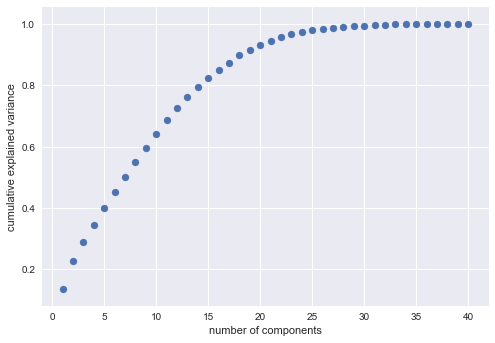

In [88]:
# Separate soil data from X_train

X_train_less_soil = X_train.drop([i for i in X_train.columns if "Soil_Type" in i],axis=1)
X_test_less_soil = X_test.drop([i for i in X_test.columns if "Soil_Type" in i],axis=1)

soil_train = X_train[[i for i in X_train.columns if "Soil_Type" in i]]
soil_test = X_test[[i for i in X_test.columns if "Soil_Type" in i]]

pca = PCA(n_components=40)
pca.fit(soil_train)
plt.scatter(range(1,41),np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

**We see that with only 15 components that we preserve about 80% of the variation.**

In [89]:
# Fit PCA and transform train and test data
p = PCA(n_components=15)
pca_soil_train = p.fit_transform(soil_train)
pca_soil_test = p.transform(soil_test)

# Convert back to Dataframes
pca_soil_train = pd.DataFrame(pca_soil_train)
pca_soil_test = pd.DataFrame(pca_soil_test)

# Make sure they're still on same index
pca_soil_train.index = soil_train.index
pca_soil_test.index = soil_test.index

# Put data back together
soil_pca_X_train = pd.concat([X_train_less_soil,pca_soil_train],axis=1,join_axes=[X_train_less_soil.index])
soil_pca_X_test = pd.concat([X_test_less_soil,pca_soil_test],axis=1,join_axes=[X_test_less_soil.index])

RF = RandomForestClassifier()

RF.fit(X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(X_test, y_test)))

RF.fit(soil_pca_X_train, y_train)
print("The accuracy score before PCA reduction was: {}".format(RF.score(soil_pca_X_test, y_test)))

The accuracy score before PCA reduction was: 0.8476953907815631
The accuracy score before PCA reduction was: 0.8585170340681363


A feature that we thought would be helpful to engineer would be the  slope of the elevation based on the elevation and the horizontal distance to hydrology.  However, by engineering this feature, we didn't see much improvement and therefore this feature was discarded.

In [107]:
#Adjusting distance to hydrology and roadways 
slope_train = pd.DataFrame()
slope_test = pd.DataFrame()

#Elevation adjusted by Horizontal distance to Hyrdrology 
slope_train['slope_hyd'] = np.sqrt(X_train.Vertical_Distance_To_Hydrology**2 + X_train.Horizontal_Distance_To_Hydrology**2) 
slope_train.slope_hyd=slope_train.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_train['slope_hyd_pct'] = X_train.Vertical_Distance_To_Hydrology / X_train.Horizontal_Distance_To_Hydrology
slope_train.slope_hyd_pct=slope_train.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_test['slope_hyd'] = np.sqrt(X_test.Vertical_Distance_To_Hydrology**2 + X_test.Horizontal_Distance_To_Hydrology**2) 
slope_test.slope_hyd=slope_test.slope_hyd.map(lambda x: 0 if np.isnan(x) else x) 
slope_test['slope_hyd_pct'] = X_test.Vertical_Distance_To_Hydrology / X_test.Horizontal_Distance_To_Hydrology
slope_test.slope_hyd_pct=slope_test.slope_hyd_pct.map(lambda x: 0 if np.isnan(x) else x)

slope_train.index = X_train.index
slope_test.index = X_test.index

X_train_slope = pd.concat([X_train,slope_train], axis =1, join_axes=[X_train.index])
X_test_slope = pd.concat([X_test,slope_test], axis=1, join_axes=[X_test.index])

# Test on a model

without_slope = []
with_slope = []
for i in range(10):
    log = RandomForestClassifier()
    log.fit(X_train, y_train)
    without_slope.append(log.score(X_test, y_test))

    log.fit(X_train_slope, y_train)
    with_slope.append(log.score(X_test_slope, y_test))
print ("Accuracy without extra slope feature is {}".format(np.mean(without_slope)))
print ("Accuracy with extra slope feature is {}".format(np.mean(with_slope)))

Accuracy without extra slope feature is 0.8497194388777555
Accuracy with extra slope feature is 0.847434869739479


## Features that didn't work

### Binning hillshade_9am

In [108]:
def bin_hillshade_9am_feat(data):
    new_data = data.copy(deep=True)

    noon_bins = np.linspace(0, 255, 8)
    which_bin = np.digitize(new_data.Hillshade_9am, bins=noon_bins)
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(which_bin.reshape(-1, 1))
    X_noon_binned = pd.DataFrame(encoder.transform(which_bin.reshape(-1, 1)))

    new_data = pd.concat([new_data, X_noon_binned], axis=1)

    return new_data

In [109]:
new_data = bin_hillshade_9am_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8244
Base LR:  0.6772, New LR:  0.6772


## Convert aspect to cardinal direction (north, south, east, west)

In [110]:
def convert_to_cardinal_feat(data):
    new_data = data.copy(deep=True)
    dir_labels = ['north east', 'east north', 'east south', 'south east', 
              'south west', 'west south', 'west north', 'north west']
    new_data.loc[:, ('direction')] = pd.cut(data.loc[:, ('Aspect')], range(0, 365, 45), right=False, labels=dir_labels)

    new_data.direction = new_data.direction.replace('east north', 'north') \
        .replace('north west', 'north') \
        .replace('east north', 'east').replace('east south', 'east').replace('south east', 'south') \
        .replace('south west', 'south').replace('west south', 'west').replace('west north', 'west') \
        .replace('north east', 'north')

    new_data = pd.get_dummies(new_data)
    return new_data

In [111]:
new_data = convert_to_cardinal_feat(data)
print_base_results(new_data)

Base RFC: 0.8192, New RFC: 0.8108
Base LR:  0.6772, New LR:  0.6794
